# Quick start using graph-tool

*exported as notebook from [here](https://graph-tool.skewed.de/static/doc/quickstart.html) by [@eliaswalyba](https://twitter.com/eliaswalyba)*

The graph_tool module provides a Graph class and several algorithms that operate on it. The internals of this class, and of most algorithms, are written in C++ for performance, using the Boost Graph Library.

The module must be of course imported before it can be used. The package is subdivided into several sub-modules. To import everything from all of them, one can do:

In [2]:
from graph_tool.all import *

In the following, it will always be assumed that the previous line was run.

## Creating and manipulating graphs

An empty graph can be created by instantiating a **Graph** class:

In [3]:
g = Graph()

By default, newly created graphs are always directed. To construct undirected graphs, one must pass a value to the directed parameter:

In [4]:
ug = Graph(directed=False)

A graph can always be switched on-the-fly from directed to undirected (and vice versa), with the set_directed() method. The “directedness” of the graph can be queried with the is_directed() method,

In [5]:
ug = Graph()
ug.set_directed(False)
print(ug.is_directed() == False)

True


A graph can also be created by providing another graph, in which case the entire graph (and its internal property maps, see Property maps) is copied:

In [6]:
g1 = Graph()
g2 = Graph(g1)

Above, g2 is a “deep” copy of g1, i.e. any modification of g2 will not affect g1.

Once a graph is created, it can be populated with vertices and edges. A vertex can be added with the add_vertex() method, which returns an instance of a Vertex class, also called a vertex descriptor. For instance, the following code creates two vertices, and returns vertex descriptors stored in the variables v1 and v2.

In [7]:
v1 = g.add_vertex()
v2 = g.add_vertex()

Edges can be added in an analogous manner, by calling the add_edge() method, which returns an edge descriptor (an instance of the Edge class):

In [8]:
e = g.add_edge(v1, v2)

The above code creates a directed edge from v1 to v2. We can visualize the graph we created so far with the graph_draw() function.

In [9]:
graph_draw(g, vertex_text=g.vertex_index, output="graph.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1920fd2400, at 0x7f1920eac490>

<img src="graph.png" width=250 height=250/>
<p style="text-align: center;">A simple directed graph with two vertices and one edge, created by the commands above.</p>

With vertex and edge descriptors, one can examine and manipulate the graph in an arbitrary manner. For instance, in order to obtain the out-degree of a vertex, we can simply call the out_degree() method:

In [10]:
print(v1.out_degree())

1


Analogously, we could have used the in_degree() method to query the in-degree.

**Note**: For undirected graphs, the “out-degree” is synonym for degree, and in this case the in-degree of a vertex is always zero.

Edge descriptors have two useful methods, source() and target(), which return the source and target vertex of an edge, respectively.

In [11]:
print(e.source(), e.target())

0 1


The add_vertex() method also accepts an optional parameter which specifies the number of vertices to create. If this value is greater than 1, it returns an iterator on the added vertex descriptors:

In [12]:
vlist = g.add_vertex(10)
print(len(list(vlist)))

10


Each vertex in a graph has an unique index, which is always between 0 and N−1, where N is the number of vertices. This index can be obtained by using the vertex_index attribute of the graph (which is a property map, see Property maps), or by converting the vertex descriptor to an int.

In [13]:
v = g.add_vertex()
print(g.vertex_index[v])
print(int(v))

12
12


Edges and vertices can also be removed at any time with the remove_vertex() and remove_edge() methods

In [14]:
g.remove_edge(e)                               # e no longer exists
g.remove_vertex(v2)                # the second vertex is also gone

**Note**: Removing a vertex is typically an O(N) operation. The vertices are internally stored in a STL vector, so removing an element somewhere in the middle of the list requires the shifting of the rest of the list. Thus, fast O(1) removals are only possible either if one can guarantee that only vertices in the end of the list are removed (the ones last added to the graph), or if the relative vertex ordering is invalidated. The latter behavior can be achieved by passing the option fast == True, to remove_vertex(), which causes the vertex being deleted to be ‘swapped’ with the last vertex (i.e. with the largest index), which will in turn inherit the index of the vertex being deleted.

**Warning**: Because of the above, removing a vertex with an index smaller than N−1 will invalidate either the last (fast = True) or all (fast = False) descriptors pointing to vertices with higher index.

As a consequence, if more than one vertex is to be removed at a given time, they should always be removed in decreasing index order:

```python
# 'del_list' is a list of vertex descriptors
for v in reversed(sorted(del_list)):
    g.remove_vertex(v)
```

Alternatively (and preferably), a list (or any iterable) may be passed directly as the vertex parameter of the remove_vertex() function, and the above is performed internally (in C++).

Note that property map values (see Property maps) are unaffected by the index changes due to vertex removal, as they are modified accordingly by the library.

**Note**: Removing an edge is an O(ks+kt) operation, where ks is the out-degree of the source vertex, and kt is the in-degree of the target vertex. This can be made faster by setting set_fast_edge_removal() to True, in which case it becomes O(1), at the expense of additional data of size O(E).
No edge descriptors are ever invalidated after edge removal, with the exception of the edge being removed.

Since vertices are uniquely identifiable by their indexes, there is no need to keep the vertex descriptor lying around to access them at a later point. If we know its index, we can obtain the descriptor of a vertex with a given index using the vertex() method,

In [15]:
v = g.vertex(8)

which takes an index, and returns a vertex descriptor. Edges cannot be directly obtained by its index, but if the source and target vertices of a given edge are known, it can be retrieved with the edge() method

In [16]:
g.add_edge(g.vertex(2), g.vertex(3))
e = g.edge(2, 3)

Another way to obtain edge or vertex descriptors is to iterate through them, as described in section Iterating over vertices and edges. This is in fact the most useful way of obtaining vertex and edge descriptors.

Like vertices, edges also have unique indexes, which are given by the edge_index property:

In [17]:
e = g.add_edge(g.vertex(0), g.vertex(1))
print(g.edge_index[e])

1


Differently from vertices, edge indexes do not necessarily conform to any specific range. If no edges are ever removed, the indexes will be in the range [0,E−1], where E is the number of edges, and edges added earlier have lower indexes. However if an edge is removed, its index will be “vacant”, and the remaining indexes will be left unmodified, and thus will not all lie in the range [0,E−1]. If a new edge is added, it will reuse old indexes, in an increasing order.

### Iterating over vertices and edges

Algorithms must often iterate through vertices, edges, out-edges of a vertex, etc. The Graph and Vertex classes provide different types of iterators for doing so. The iterators always point to edge or vertex descriptors.

#### Iterating over all vertices or edges

In order to iterate through all the vertices or edges of a graph, the vertices() and edges() methods should be used:

In [18]:
for v in g.vertices():
    print(v)
for e in g.edges():
    print(e)

0
1
2
3
4
5
6
7
8
9
10
11
(0, 1)
(2, 3)


The code above will print the vertices and edges of the graph in the order they are found.

#### Iterating over the neighborhood of a vertex

The out- and in-edges of a vertex, as well as the out- and in-neighbors can be iterated through with the out_edges(), in_edges(), out_neighbors() and in_neighbors() methods, respectively.

In [19]:
for v in g.vertices():
   for e in v.out_edges():
       print(e)
   for w in v.out_neighbors():
       print(w)

   # the edge and neighbors order always match
   for e, w in zip(v.out_edges(), v.out_neighbors()):
       assert e.target() == w

(0, 1)
1
(2, 3)
3


The code above will print the out-edges and out-neighbors of all vertices in the graph.

**Warning**: You should never remove vertex or edge descriptors when iterating over them, since this invalidates the iterators. If you plan to remove vertices or edges during iteration, you must first store them somewhere (such as in a list) and remove them only after no iterator is being used. Removal during iteration will cause bad things to happen.

#### Fast iteration over vertices and edges

While convenient, looping over the graph as described in the previous section is not the most efficient approach. This is because the loops are performed in pure Python, and hence it undermines the main feature of the library, which is the offloading of loops from Python to C++. Following the numpy philosophy, graph_tool also provides an array-based interface that avoids loops in Python. This is done with the get_vertices(), get_edges(), get_out_edges(), get_in_edges(), get_all_edges(), get_out_neighbors(), get_in_neighbors(), get_all_neighbors(), get_out_degrees(), get_in_degrees() and get_total_degrees() methods, which return numpy.ndarray instances instead of iterators.

For example, using this interface we can get the out-degree of each node via:

In [20]:
print(g.get_out_degrees(g.get_vertices()))

[1 0 1 0 0 0 0 0 0 0 0 0]


or the sum of the product of the in and out-degrees of the endpoints of each edge with:

In [21]:
edges = g.get_edges()
in_degs = g.get_in_degrees(g.get_vertices())
out_degs = g.get_out_degrees(g.get_vertices())
print((out_degs[edges[:,0]] * in_degs[edges[:,1]]).sum())

2


## Property maps

Property maps are a way of associating additional information to the vertices, edges or to the graph itself. There are thus three types of property maps: vertex, edge and graph. They are handled by the classes VertexPropertyMap, EdgePropertyMap, and GraphPropertyMap. Each created property map has an associated value type, which must be chosen from the predefined set:

<table class="docutils align-default">
<colgroup>
<col style="width: 38%">
<col style="width: 62%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Type name</p></th>
<th class="head"><p>Alias</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">bool</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">uint8_t</span></code></p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">int16_t</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">short</span></code></p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">int32_t</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">int</span></code></p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">int64_t</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">long</span></code>, <code class="docutils literal notranslate"><span class="pre">long</span> <span class="pre">long</span></code></p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">double</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">float</span></code></p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">long</span> <span class="pre">double</span></code></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">string</span></code></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;bool&gt;</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;uint8_t&gt;</span></code></p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;int16_t&gt;</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;short&gt;</span></code></p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;int32_t&gt;</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;int&gt;</span></code></p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;int64_t&gt;</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;long&gt;</span></code>, <code class="docutils literal notranslate"><span class="pre">vector&lt;long</span> <span class="pre">long&gt;</span></code></p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;double&gt;</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;float&gt;</span></code></p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;long</span> <span class="pre">double&gt;</span></code></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">vector&lt;string&gt;</span></code></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">python::object</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">object</span></code></p></td>
</tr>
</tbody>
</table>

New property maps can be created for a given graph by calling one of the methods new_vertex_property() (alias new_vp()), new_edge_property() (alias new_ep()), or new_graph_property() (alias new_gp()), for each map type. The values are then accessed by vertex or edge descriptors, or the graph itself, as such:

In [22]:
from numpy.random import randint

g = Graph()
g.add_vertex(100)

# insert some random links
for s,t in zip(randint(0, 100, 100), randint(0, 100, 100)):
    g.add_edge(g.vertex(s), g.vertex(t))

vprop_double = g.new_vertex_property("double")            # Double-precision floating point
v = g.vertex(10)
vprop_double[v] = 3.1416

vprop_vint = g.new_vertex_property("vector<int>")         # Vector of ints
v = g.vertex(40)
vprop_vint[v] = [1, 3, 42, 54]

eprop_dict = g.new_edge_property("object")                # Arbitrary Python object.
e = g.edges().next()
eprop_dict[e] = {"foo": "bar", "gnu": 42}                 # In this case, a dict.

gprop_bool = g.new_graph_property("bool")                 # Boolean
gprop_bool[g] = True

Property maps with scalar value types can also be accessed as a numpy.ndarray, with the get_array() method, or the a attribute, e.g.,

In [23]:
from numpy.random import random

# this assigns random values to the vertex properties
vprop_double.get_array()[:] = random(g.num_vertices())

# or more conveniently (this is equivalent to the above)
vprop_double.a = random(g.num_vertices())

### Internal property maps

Any created property map can be made “internal” to the corresponding graph. This means that it will be copied and saved to a file together with the graph. Properties are internalized by including them in the graph’s dictionary-like attributes vertex_properties, edge_properties or graph_properties (or their aliases, vp, ep or gp, respectively). When inserted in the graph, the property maps must have an unique name (between those of the same type):

In [24]:
eprop = g.new_edge_property("string")
g.edge_properties["some name"] = eprop
g.list_properties()

some name      (edge)    (type: string)


Internal graph property maps behave slightly differently. Instead of returning the property map object, the value itself is returned from the dictionaries:

In [25]:
gprop = g.new_graph_property("int")
g.graph_properties["foo"] = gprop   # this sets the actual property map
g.graph_properties["foo"] = 42      # this sets its value
print(g.graph_properties["foo"])
del g.graph_properties["foo"]       # the property map entry is deleted from the dictionary

42


For convenience, the internal property maps can also be accessed via attributes:

In [26]:
vprop = g.new_vertex_property("double")
g.vp.foo = vprop                        # equivalent to g.vertex_properties["foo"] = vprop
v = g.vertex(0)
g.vp.foo[v] = 3.14
print(g.vp.foo[v])

3.14


## Graph I/O

Graphs can be saved and loaded in four formats: graphml, dot, gml and a custom binary format gt (see The gt file format).

**Warning**: The binary format gt and the text-based graphml are the preferred formats, since they are by far the most complete. Both these formats are equally complete, but the gt format is faster and requires less storage.
The dot and gml formats are fully supported, but since they contain no precise type information, all properties are read as strings (or also as double, in the case of gml), and must be converted by hand to the desired type. Therefore you should always use either gt or graphml, since they implement an exact bit-for-bit representation of all supported Property maps types, except when interfacing with other software, or existing data, which uses dot or gml.

A graph can be saved or loaded to a file with the save and load methods, which take either a file name or a file-like object. A graph can also be loaded from disc with the load_graph() function, as such:

In [28]:
g = Graph()
#  ... fill the graph ...
g.save("my_graph.xml.gz")
g2 = load_graph("my_graph.xml.gz")
# g and g2 should be copies of each other

## An Example: Building a Price Network

A Price network is the first known model of a “scale-free” graph, invented in 1976 by de Solla Price. It is defined dynamically, where at each time step a new vertex is added to the graph, and connected to an old vertex, with probability proportional to its in-degree. The following program implements this construction using graph-tool.

**Note**: Note that it would be much faster just to use the price_network() function, which is implemented in C++, as opposed to the script below which is in pure Python. The code below is merely a demonstration on how to use the library.

vertex: 36063 in-degree: 0 out-degree: 1 age: 36063
vertex: 9075 in-degree: 4 out-degree: 1 age: 9075
vertex: 5967 in-degree: 3 out-degree: 1 age: 5967
vertex: 1113 in-degree: 7 out-degree: 1 age: 1113
vertex: 25 in-degree: 84 out-degree: 1 age: 25
vertex: 10 in-degree: 541 out-degree: 1 age: 10
vertex: 5 in-degree: 140 out-degree: 1 age: 5
vertex: 2 in-degree: 459 out-degree: 1 age: 2
vertex: 1 in-degree: 520 out-degree: 1 age: 1
vertex: 0 in-degree: 210 out-degree: 0 age: 0
Nowhere else to go... We found the main hub!


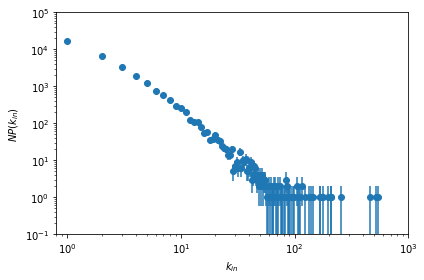

In [32]:
#! /usr/bin/env python

# We will need some things from several places
from __future__ import division, absolute_import, print_function
import sys
if sys.version_info < (3,):
    range = xrange
import os
from pylab import *  # for plotting
from numpy.random import *  # for random sampling
seed(42)

# We need to import the graph_tool module itself
from graph_tool.all import *

# let's construct a Price network (the one that existed before Barabasi). It is
# a directed network, with preferential attachment. The algorithm below is
# very naive, and a bit slow, but quite simple.

# We start with an empty, directed graph
g = Graph()

# We want also to keep the age information for each vertex and edge. For that
# let's create some property maps
v_age = g.new_vertex_property("int")
e_age = g.new_edge_property("int")

# The final size of the network
N = 100000

# We have to start with one vertex
v = g.add_vertex()
v_age[v] = 0

# we will keep a list of the vertices. The number of times a vertex is in this
# list will give the probability of it being selected.
vlist = [v]

# let's now add the new edges and vertices
for i in range(1, N):
    # create our new vertex
    v = g.add_vertex()
    v_age[v] = i

    # we need to sample a new vertex to be the target, based on its in-degree +
    # 1. For that, we simply randomly sample it from vlist.
    i = randint(0, len(vlist))
    target = vlist[i]

    # add edge
    e = g.add_edge(v, target)
    e_age[e] = i

    # put v and target in the list
    vlist.append(target)
    vlist.append(v)

# now we have a graph!

# let's do a random walk on the graph and print the age of the vertices we find,
# just for fun.

v = g.vertex(randint(0, g.num_vertices()))
while True:
    print("vertex:", int(v), "in-degree:", v.in_degree(), "out-degree:",
          v.out_degree(), "age:", v_age[v])

    if v.out_degree() == 0:
        print("Nowhere else to go... We found the main hub!")
        break

    n_list = []
    for w in v.out_neighbors():
        n_list.append(w)
    v = n_list[randint(0, len(n_list))]

# let's save our graph for posterity. We want to save the age properties as
# well... To do this, they must become "internal" properties:

g.vertex_properties["age"] = v_age
g.edge_properties["age"] = e_age

# now we can save it
g.save("price.xml.gz")


# Let's plot its in-degree distribution
in_hist = vertex_hist(g, "in")

y = in_hist[0]
err = sqrt(in_hist[0])
err[err >= y] = y[err >= y] - 1e-2

figure(figsize=(6,4))
errorbar(in_hist[1][:-1], in_hist[0], fmt="o", yerr=err,
        label="in")
gca().set_yscale("log")
gca().set_xscale("log")
gca().set_ylim(1e-1, 1e5)
gca().set_xlim(0.8, 1e3)
subplots_adjust(left=0.2, bottom=0.2)
xlabel("$k_{in}$")
ylabel("$NP(k_{in})$")
tight_layout()
savefig("price-deg-dist.pdf")
savefig("price-deg-dist.svg")

In-degree distribution of a price network with 105 nodes.

Above is the degree distribution, with 105 nodes (in order to the asymptotic behavior to be even clearer, the number of vertices needs to be increased to something like 106 or 107).

We can draw the graph to see some other features of its topology. For that we use the graph_draw() function.

In [36]:
g = load_graph("price.xml.gz")
age = g.vertex_properties["age"]

pos = sfdp_layout(g)
graph_draw(g, pos, output_size=(1000, 1000), vertex_color=[1,1,1,0],
           vertex_fill_color=age, vertex_size=1, edge_pen_width=1.2,
           vcmap=matplotlib.cm.gist_heat_r, output="price.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f18ed1f0070, at 0x7f18e85f9370>

<img src="price.png" width=750 height=750 />
<p style="text-align: center;">A Price network with 105 nodes. The vertex colors represent the age of the vertex, from older (red) to newer (black).</p>

## Graph filtering

One of the very nice features of graph-tool is the “on-the-fly” filtering of edges and/or vertices. Filtering means the temporary masking of vertices/edges, which are in fact not really removed, and can be easily recovered. Vertices or edges which are to be filtered should be marked with a PropertyMap with value type bool, and then set with set_vertex_filter() or set_edge_filter() methods. By default, vertex or edges with value “1” are kept in the graphs, and those with value “0” are filtered out. This behaviour can be modified with the inverted parameter of the respective functions. All manipulation functions and algorithms will work as if the marked edges or vertices were removed from the graph, with minimum overhead.

**Note**: It is important to emphasize that the filtering functionality does not add any overhead when the graph is not being filtered. In this case, the algorithms run just as fast as if the filtering functionality didn’t exist.

Here is an example which obtains the minimum spanning tree of a graph, using the function min_spanning_tree() and edge filtering.

In [41]:
g, pos = triangulation(random((500, 2)) * 4, type="delaunay")
tree = min_spanning_tree(g)
graph_draw(g, pos=pos, edge_color=tree, output="min_tree.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f18ed210e20, at 0x7f18ed210a90>

The tree property map has a bool type, with value “1” if the edge belongs to the tree, and “0” otherwise. Below is an image of the original graph, with the marked edges.

<img src="min_tree.svg" width=500 height=500 />

We can now filter out the edges which don’t belong to the minimum spanning tree.

In [42]:
g.set_edge_filter(tree)
graph_draw(g, pos=pos, output="min_tree_filtered.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f18ed210e20, at 0x7f18ed210a90>

This is how the graph looks when filtered:

<img src="min_tree_filtered.svg" height=500 width=500 />

Everything should work transparently on the filtered graph, simply as if the masked edges were removed. For instance, the following code will calculate the betweenness() centrality of the edges and vertices, and draws them as colors and line thickness in the graph.

In [43]:
bv, be = betweenness(g)
be.a /= be.a.max() / 5
graph_draw(g, pos=pos, vertex_fill_color=bv, edge_pen_width=be,
           output="filtered-bt.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f18ed210e20, at 0x7f18ed210a90>

<img src="filtered-bt.svg" height=500 width=500 />

The original graph can be recovered by setting the edge filter to None.

In [44]:
g.set_edge_filter(None)
bv, be = betweenness(g)
be.a /= be.a.max() / 5
graph_draw(g, pos=pos, vertex_fill_color=bv, edge_pen_width=be,
           output="nonfiltered-bt.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f18ed210e20, at 0x7f18ed210a90>

<img src="nonfiltered-bt.svg" height=500 width=500 />

Everything works in analogous fashion with vertex filtering.

Additionally, the graph can also have its edges reversed with the set_reversed() method. This is also an O(1) operation, which does not really modify the graph.

As mentioned previously, the directedness of the graph can also be changed “on-the-fly” with the set_directed() method.

### Graph views

It is often desired to work with filtered and unfiltered graphs simultaneously, or to temporarily create a filtered version of graph for some specific task. For these purposes, graph-tool provides a GraphView class, which represents a filtered “view” of a graph, and behaves as an independent graph object, which shares the underlying data with the original graph. Graph views are constructed by instantiating a GraphView class, and passing a graph object which is supposed to be filtered, together with the desired filter parameters. For example, to create a directed view of the graph g constructed above, one should do:

In [45]:
ug = GraphView(g, directed=True)
ug.is_directed()

True

Graph views also provide a much more direct and convenient approach to vertex/edge filtering: To construct a filtered minimum spanning tree like in the example above, one must only pass the filter property as the “efilt” parameter:

In [46]:
tv = GraphView(g, efilt=tree)

Note that this is an O(1) operation, since it is equivalent (in speed) to setting the filter in graph g directly, but in this case the object g remains unmodified.

Like above, the result should be the isolated minimum spanning tree:

In [47]:
bv, be = betweenness(tv)
be.a /= be.a.max() / 5
graph_draw(tv, pos=pos, vertex_fill_color=bv, edge_pen_width=be, output="mst-view.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f18ed210e20, at 0x7f18ed210a90>

<img src="mst-view.svg" height=500 width=500/>
<p style="text-align: center;">A view of the Delaunay graph, isolating only the minimum spanning tree</p>

**Note**: GraphView objects behave exactly like regular Graph objects. In fact, GraphView is a subclass of Graph. The only difference is that a GraphView object shares its internal data with its parent Graph class. Therefore, if the original Graph object is modified, this modification will be reflected immediately in the GraphView object, and vice versa.

For even more convenience, one can supply a function as filter parameter, which takes a vertex or an edge as single parameter, and returns True if the vertex/edge should be kept and False otherwise. For instance, if we want to keep only the most “central” edges, we can do:

In [49]:
bv, be = betweenness(g)
u = GraphView(g, efilt=lambda e: be[e] > be.a.max() / 2)

This creates a graph view u which contains only the edges of g which have a normalized betweenness centrality larger than half of the maximum value. Note that, differently from the case above, this is an O(E) operation, where E is the number of edges, since the supplied function must be called E times to construct a filter property map. Thus, supplying a constructed filter map is always faster, but supplying a function can be more convenient.

The graph view constructed above can be visualized as

In [50]:
be.a /= be.a.max() / 5
graph_draw(u, pos=pos, vertex_fill_color=bv, output="central-edges-view.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f18ed210e20, at 0x7f18ed210a90>

<img src="central-edges-view.svg" height=500 width=500 />

#### Composing graph views

Since graph views are regular graphs, one can just as easily create graph views of graph views. This provides a convenient way of composing filters. For instance, in order to isolate the minimum spanning tree of all vertices of the example above which have a degree larger than four, one can do:

In [51]:
u = GraphView(g, vfilt=lambda v: v.out_degree() > 4)
tree = min_spanning_tree(u)
u = GraphView(u, efilt=tree)

The resulting graph view can be visualized as

In [52]:
graph_draw(u, pos=pos, output="composed-filter.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f18ed210e20, at 0x7f18ed210a90>

<img src="composed-filter.svg" height=500 width=500 />
<p style="text-align: center;">A composed view, obtained as the minimum spanning tree of all vertices in the graph which have a degree larger than four.</p>

A composed view, obtained as the minimum spanning tree of all vertices in the graph which have a degree larger than four.